# Лабоаторная работа 2
## Линейная регрессия

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**1.** Загрузите датасет с успеваемостью студентов (https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)

   Изучите признаки: их шкалу, тип данных, наличие пропусков, распределение. Нашей целевой переменной будет последняя колонка - Performance Index

In [3]:
data = pd.read_csv('Student_Performance.csv')
data.head()
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None
       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        54.000000      5.

Переведите все фичи в числа и сохраните в переменной Х формата np.array. Целевую колонку сохраните в массив y. Для превращения в массив можно использовать df.values. Постройте корреляционную матрицу (это можно сделать как за счет numpy, так и с исходным датафреймом, если выделить из него только числовые колонки)

Разбейте данные на тренировочный и тестовый наборы в отношении 80:20

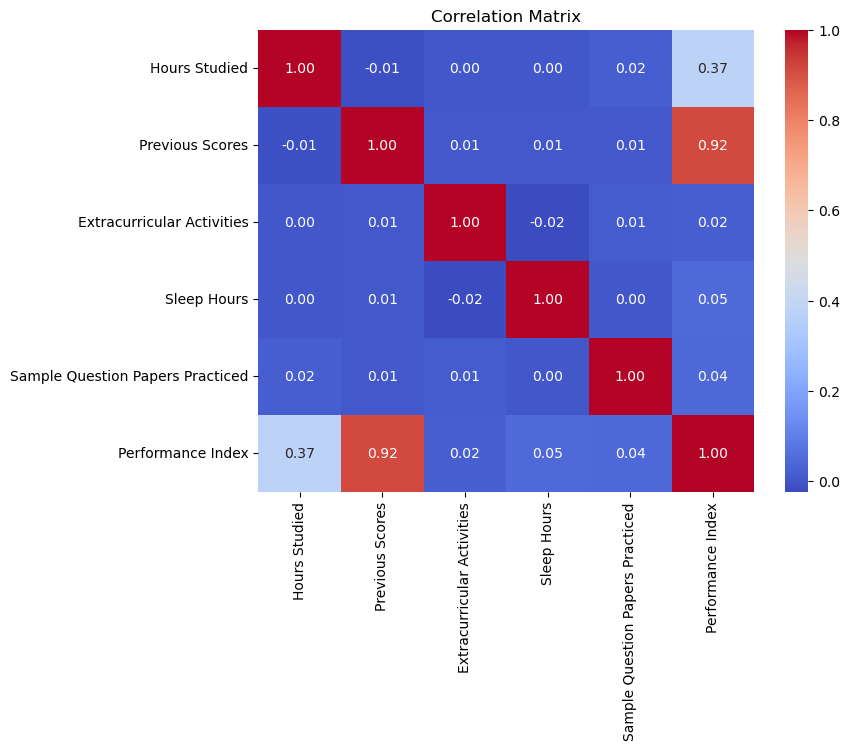

X_train shape: (8000, 5)
X_test shape: (2000, 5)


In [8]:
from sklearn.model_selection import train_test_split

data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

X = data.drop('Performance Index', axis=1).values
y = data['Performance Index'].values

corr_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

**2.** На основе базовых классов из sklearn напишите свою линейную регрессию, где коэффициенты находятся с помощью псевдообратной матрицы. Не забудьте про свободный член! Он должен откуда-то появиться.
   $$ w = (X^TX)^{-1} X^T y$$

Второй регрессор напишите с градиентным спуском (мы тут не будем рассматривать стохастический и мини-батч, хотя, если интересно, можете и их заимплементить). Подумайте, как вы будете решать, когда должен остановиться градиентный спуск. По результатам измышлений допишите еще входных параметров в метод \__init__. В качестве функции потерь выберем MSE. В матричной записи она будет выглядеть как $\frac{1}{N}(Xw - y)^T(Xw - y).$ Дифференцируя ее по $w$, получим $$\frac{2}{N} X^T(Xw - y).$$ Формула с псевдообратной матрицей, кстати, получается, если приравнять это к 0 и выразить $w$.

Мы хотим двигаться в направлении, противоположном этому, т.е. эта величина, умноженная на скорость обучения (learning rate), отнимается от текущих весов. Коэффициент 2 из нее поэтому можно и убрать, он войдет в lr, а вот убирать $N$, пожалуй, не стоит.

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin

In [11]:
class PseudoInvRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        # w = (X^T * X)^-1 * X^T * y
        self.w_ = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

        return self

    def predict(self, X):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        # y = X * w
        return X_b @ self.w_  # predictions

In [12]:
class GradRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lr=0.001, max_iter=1_000, tol=1e-5):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.w_ = np.zeros(6)
        self.losses_ = []

    def fit(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        n_samples, n_features = X_b.shape

        self.w_ = np.ones(n_features)

        for i in range(self.max_iter):
            y_pred = X_b @ self.w_
            
            loss = np.mean((y_pred - y) ** 2)
            self.losses_.append(loss)

            grad = (1 / n_samples) * X_b.T @ (y_pred - y)
            if np.linalg.norm(grad) < self.tol:
                break

            # 2/N * X^T(Xw - y)
            self.w_ -= self.lr * grad

        return self

    def predict(self, X):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        return X_b @ self.w_  # predictions

Обучите оба регрессора на загруженных данных. Для второго регрессора придется поэкспериментировать со скоростью и продолжительностью обучения. Постройте график ошибок. 

Weights (PseudoInvRegressor):  [-33.92194622   2.85248393   1.0169882    0.60861668   0.47694148
   0.19183144]
Weights (GradRegressor):  [-0.48913398  2.20646692  0.81553194  0.24638651 -1.50733855 -0.27956614]


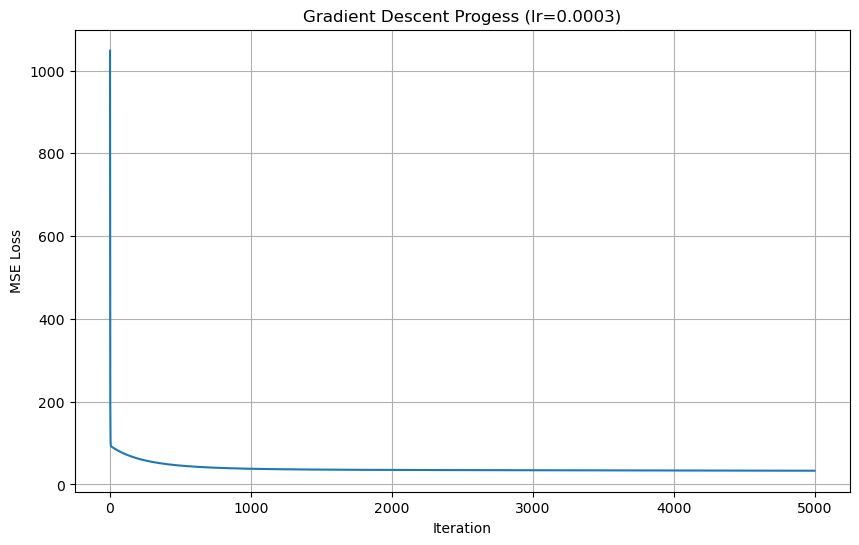


MSE test (PseudoInvRegressor): 4.0826
MSE test (GradDescent): 35.2007


In [13]:
from sklearn.metrics import mean_squared_error

pseudo_reg = PseudoInvRegressor()
pseudo_reg.fit(X_train, y_train)

print("Weights (PseudoInvRegressor): ", pseudo_reg.w_)

lr = 0.0003
grad_reg = GradRegressor(lr=lr, max_iter=5000)
grad_reg.fit(X_train, y_train)

print("Weights (GradRegressor): ", grad_reg.w_)

plt.figure(figsize=(10, 6))
plt.plot(grad_reg.losses_)
plt.title(f"Gradient Descent Progess (lr={lr})")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

y_pred_pseudo = pseudo_reg.predict(X_test)
y_pred_grad = grad_reg.predict(X_test)

mse_pseudo = mean_squared_error(y_test, y_pred_pseudo)
mse_grad = mean_squared_error(y_test, y_pred_grad)
    
    
print(f"\nMSE test (PseudoInvRegressor): {mse_pseudo:.4f}")
print(f"MSE test (GradDescent): {mse_grad:.4f}")

**3.** Попробуйте нормализовать или стандартизировать данные, и повторите попытку для обоих регрессоров. Для этого воспользуйтесь скейлерами из sklearn. Метод fit_transform позволяет сразу и настроить параметры скейлера и выполнить масштабирование. **Внимание!** Обучать (fit) скейлер нужно только на тренировочных данных. А потом с полученными на них параметрами применять его к тестовым. **Еще внимание!** Если в вашей матрице $X$ был столбик для свободного члена, после масштабирования он станет нулевым. Это не то, чего нам бы хотелось, это надо пофиксить

Итак, что изменилось?

Контрольные вопросы: зачем масштабировать данные? Когда это обязательно, когда не очень? Надо ли масштабировать $y$? Зачем градиентный регрессор (а он имплементирован не только вами, но и авторами sklearn), если можно найти псевдообратную матрицу, которая является оптимальным решением?

MSE (PseudoInv + Scaling): 4.0826
MSE (GradDescent + Scaling): 4.0826


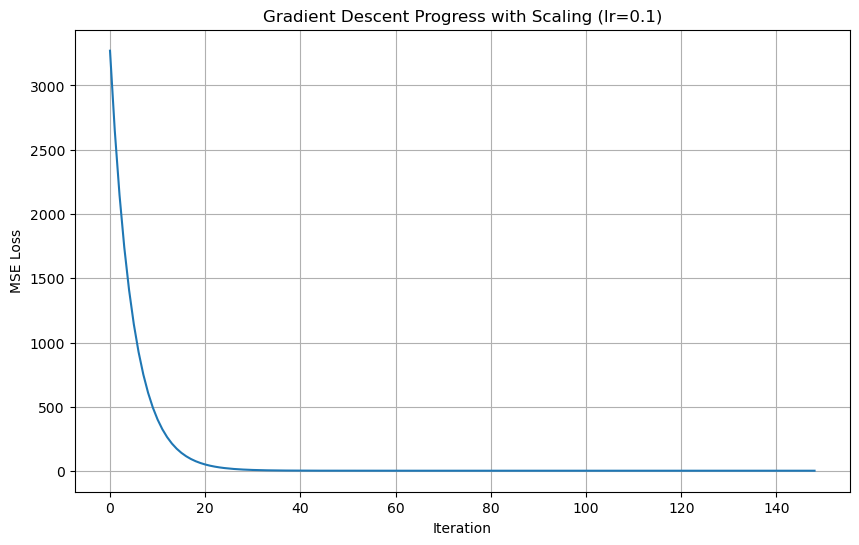

[55.3115      7.40134079 17.63727127  0.30429076  0.81003107  0.54884171]
[55.31149082  7.40133904 17.63726811  0.30429113  0.81003133  0.54884264]


In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

pseudo_reg_scaled = PseudoInvRegressor()
pseudo_reg_scaled.fit(X_train_scaled, y_train)
y_pred_pseudo_scaled = pseudo_reg_scaled.predict(X_test_scaled)
mse_pseudo_scaled = mean_squared_error(y_test, y_pred_pseudo_scaled)

print(f"MSE (PseudoInv + Scaling): {mse_pseudo_scaled:.4f}")

learning_rate = 0.1
iterations = 1000

grad_reg_scaled = GradRegressor(lr=learning_rate, max_iter=iterations)
grad_reg_scaled.fit(X_train_scaled, y_train)

y_pred_grad_scaled = grad_reg_scaled.predict(X_test_scaled)
mse_grad_scaled = mean_squared_error(y_test, y_pred_grad_scaled)

print(f"MSE (GradDescent + Scaling): {mse_grad_scaled:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(grad_reg_scaled.losses_)
plt.title(f"Gradient Descent Progress with Scaling (lr={learning_rate})")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

print(pseudo_reg_scaled.w_)
print(grad_reg_scaled.w_)

1. масштабировать - могут быть разные единицы измерения (часы, тонны)
2. обязательно для линейных моделей, где применяется градиентный спуск, необязательно для деревьев решений
3. масштабировать y не обязательно, если большие числа можно log
4. аналитическое решение по времени $O(n^3)$, а по памяти $O(n^2)$, для матрицы на 100_000 признаков такой трюк не пройдет

**4.** Добавим возможность l1 и l2 регуляризации. Это означает, что функция потерь примет вид

$$\frac{1}{N}\sum_{i=1}^N (y_i - X_iw)^2 + \lambda_1\sum_{j=1}^m |w_j| + \lambda_2\sum_{j=1}^m w_j^2,$$

где $\lambda_1$, $\lambda_2$ отвечают за выраженность l1 и l2 регуляризаций и могут их выключить, будучи равными 0.

Здесь мы сталкиваемся с проблемой в случае псевдообратного решения - из-за того, что модуль недифференцируем в 0, мы, вообще-то, не можем получить одну конечную формулу для решения. Но для l2 все в порядке. 

Итак, для **псевдообратного регрессора** выведите новую формулу с учетом l2-регуляризации. Выводится она из тех соображений, что искомое $w$ - это точка, где достигается экстремум функции потерь, т.е. равна 0 ее производная. Добавьте в класс этого регрессора l2-регуляризацию.

Для **градиентного регрессора** добавьте обе регуляризации (производной модуля будем считать $sgn$).

#### Вывод формулы для псевдообратной матрицы с L2-регуляризацией

Возьмем функцию потерь с L2-слагаемым:
$$ L(w) = \frac{1}{N}(Xw - y)^T(Xw - y) + \lambda_2 w^T w $$

Найдем градиент по $w$:
$$ \nabla_w L = \frac{2}{N} X^T(Xw - y) + 2\lambda_2 w \quad \rightarrow \quad
\frac{2}{N} X^T(Xw - y) + 2\lambda_2 w = 0 \quad \rightarrow \quad
\frac{1}{N} X^T X w - \frac{1}{N} X^T y + \lambda_2 w = 0 \quad \rightarrow \quad
\left( \frac{1}{N} X^T X + \lambda_2 I \right) w = \frac{1}{N} X^T y $$
$$\alpha = N \cdot \lambda_2$$
$$ (X^T X + \alpha I) w = X^T y \quad \Rightarrow \quad
w = (X^T X + \alpha I)^{-1} X^T y $$

Мы не должны штрафовать свободный член (bias, $w_0$). Поэтому в матрице $I$ на позиции $(0,0)$ должен стоять 0, а на остальных позициях диагонали — 1.

In [15]:
class PseudoInvRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lam=0.0):
        self.lam = lam
        self.w_ = np.zeros(1)

    def fit(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        dim = X_b.shape[1]
        I = np.eye(dim)  # noqa: E741
        I[0, 0] = 0

        # w = (X^T * X + lam * I)^-1 * X^T * y
        self.w_ = np.linalg.inv(X_b.T @ X_b + self.lam * I) @ X_b.T @ y

        return self

    def predict(self, X):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        # y = X * w
        return X_b @ self.w_  # predictions

In [16]:
class GradRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lr=0.001, max_iter=1_000, tol=1e-5, lam1=0.0, lam2=0.0):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.lam1 = lam1
        self.lam2 = lam2
        self.w_ = np.zeros(6)
        self.losses_ = []

    def fit(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        n_samples, n_features = X_b.shape

        self.w_ = np.ones(n_features)

        for _ in range(self.max_iter):
            y_pred = X_b @ self.w_

            error = y_pred - y

            mse_grad = (2 / n_samples) * (X_b.T @ error)

            l1_grad = self.lam1 * np.sign(self.w_)
            l1_grad[0] = 0

            l2_grad = 2 * self.lam2 * self.w_
            l2_grad[0] = 0

            grad = mse_grad + l1_grad + l2_grad
            if np.linalg.norm(grad) < self.tol:
                break

            self.w_ -= self.lr * grad

            loss = (
                np.mean(error**2)
                + self.lam1 * np.sum(np.abs(self.w_[1:]))
                + self.lam2 * np.sum(self.w_[1:] ** 2)
            )
            self.losses_.append(loss)

        return self

    def predict(self, X):
        ones = np.ones((X.shape[0], 1))
        X_b = np.hstack([ones, X])

        return X_b @ self.w_  # predictions

**5.** Обучите ваши регрессоры с этими новыми настройками. Рассмотрите 3 случая: 
- псевдообратные регрессор с l2
- градиентный регрессор с l1
- градиентный регрессор с l2

Подберите какие-то лямбды, дающие адекватный результат. Потом загрузите регрессоры из sklearn и обучите их с теми же (насколько это возможно) настройками. Сравните полученные веса и ошибку на тренировочном и тестовых множествах (выведите их куда-нибудь в одно место, вместе с параметрами, чтоб красиво. Можно, например, собрать из них маленький датафрейм)

Когда пойдете читать справку для Lasso и Ridge, обратите внимание на описываемые способы решения: в Ridge(l2) есть несколько опций, в том числе детерминированных; в Lasso(l1) используется координатный спуск.

Контрольный вопрос: почему про L1 говорят, что он отбирает признаки, а L2 - нет?

In [17]:
from sklearn.linear_model import Lasso, Ridge


lam_l2 = 1.0
lam_l1 = 0.1
lr = 0.04
max_iter = 1000

results = []


def add_result(model_name, model, X_tr, y_tr, X_te, y_te, params_note=""):
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)

    mse_train = mean_squared_error(y_tr, y_pred_train)
    mse_test = mean_squared_error(y_te, y_pred_test)

    if hasattr(model, "w_"):
        intercept = model.w_[0]
        weights = model.w_[1:]
    else:
        intercept = model.intercept_
        weights = model.coef_

    results.append({
        "Model": model_name,
        "Note": params_note,
        "Train MSE": round(mse_train, 4),
        "Test MSE": round(mse_test, 4),
        "Intercept": round(intercept, 4),
        "Weights (First 3)": [round(w, 4) for w in weights[:3]],
        "L1_Norm_Weights": round(np.sum(np.abs(weights)), 4),
    })


my_ridge = PseudoInvRegressor(lam=lam_l2)
my_ridge.fit(X_train_scaled, y_train)
add_result("My PseudoInv", my_ridge, X_train_scaled, y_train, X_test_scaled, y_test, f"L2={lam_l2}")

l2 = lam_l2 / X_train_scaled.shape[0]
my_grad_l2 = GradRegressor(lr=lr, max_iter=max_iter, lam2=l2)
my_grad_l2.fit(X_train_scaled, y_train)
add_result(
    "My GradRegressor", my_grad_l2, X_train_scaled, y_train, X_test_scaled, y_test, f"L2={lam_l2}"
)

my_grad_l1 = GradRegressor(lr=lr, max_iter=max_iter, lam1=lam_l1)
my_grad_l1.fit(X_train_scaled, y_train)
add_result(
    "My GradRegressor", my_grad_l1, X_train_scaled, y_train, X_test_scaled, y_test, f"L1={lam_l1}"
)


sk_ridge = Ridge(alpha=lam_l2, solver="cholesky")
sk_ridge.fit(X_train_scaled, y_train)
add_result(
    "Sklearn Ridge", sk_ridge, X_train_scaled, y_train, X_test_scaled, y_test, f"alpha={lam_l2}"
)

sk_lasso = Lasso(alpha=lam_l1)
sk_lasso.fit(X_train_scaled, y_train)
add_result(
    "Sklearn Lasso", sk_lasso, X_train_scaled, y_train, X_test_scaled, y_test, f"alpha={lam_l1}"
)


df_results = pd.DataFrame(results)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
print(df_results)

              Model       Note  Train MSE  Test MSE  Intercept          Weights (First 3)  L1_Norm_Weights
0      My PseudoInv     L2=1.0     4.1697    4.0832    55.3115  [7.4004, 17.6351, 0.3043]          26.6985
1  My GradRegressor     L2=1.0     4.1697    4.0832    55.3115  [7.4004, 17.6351, 0.3043]          26.6985
2  My GradRegressor     L1=0.1     4.1822    4.1160    55.3115   [7.352, 17.5874, 0.2535]          26.4523
3     Sklearn Ridge  alpha=1.0     4.1697    4.0832    55.3115  [7.4004, 17.6351, 0.3043]          26.6985
4     Sklearn Lasso  alpha=0.1     4.2196    4.1753    55.3115  [7.3027, 17.5375, 0.2027]          26.2029


**6.** Почитайте справку для класса SGDRegressor и сообразите, как сделать так, чтобы он оптимизировал MAE, а не MSE. Обучите два регрессора - один с абсолютной ошибкой, другой с квадратичной. Сравните веса, значения обеих ошибок на тренировочном и тестовом наборах

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

params = {'max_iter': 1000, 'random_state': 42, 'tol': 1e-4}

sgd_mse = SGDRegressor(loss='squared_error', **params)
sgd_mse.fit(X_train_scaled, y_train)

sgd_mae = SGDRegressor(loss='epsilon_insensitive', epsilon=0, **params)
sgd_mae.fit(X_train_scaled, y_train)

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_te)
    
    return {
        "Model (Optimizing)": name,
        "Train MSE": round(mean_squared_error(y_tr, pred_train), 4),
        "Train MAE": round(mean_absolute_error(y_tr, pred_train), 4),
        "Test MSE": round(mean_squared_error(y_te, pred_test), 4),
        "Test MAE": round(mean_absolute_error(y_te, pred_test), 4),
        "Weights (First 3)": [round(w, 4) for w in model.coef_[:3]]
    }

results_sgd = []
results_sgd.append(evaluate_model("MSE", sgd_mse, X_train_scaled, y_train, X_test_scaled, y_test))
results_sgd.append(evaluate_model("MAE", sgd_mae, X_train_scaled, y_train, X_test_scaled, y_test))

df_sgd = pd.DataFrame(results_sgd)

pd.set_option('display.max_columns', None)
print(df_sgd)

  Model (Optimizing)  Train MSE  Train MAE  Test MSE  Test MAE          Weights (First 3)
0                MSE     4.1726     1.6203    4.0858    1.6115  [7.3486, 17.6431, 0.3006]
1                MAE     4.1723     1.6189    4.0886    1.6125  [7.4143, 17.6073, 0.3244]


**7.** В датасете со студентами у нас был нормально распределенный таргет. Вообще-то это как бы не обязательно (нормальному распределению должны следовать ошибки; да и это тоже необязательно - смотря какие выводы вы хотите потом сделать о модели), но в некоторых туториалах можно встретить и такое требование. А еще в некоторых - требование нормального распределения фичей. Математического пояснения этому обычно не дается, а говорится что-то вроде "модель эффективнее обучается на нормально распределенных данных". 

Загрузите датасет с ценами медстраховки (https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset ). Масштабируйте данные, предобработайте категориальные признаки. Попробуйте скорректировать а) распределение целевой переменной б) распределения не бинарных фичей до нормального. На этих данных обучите модели настолько хорошо, насколько сможете, и сравните их качество с моделями без подобных преобразований. Сравнивать будем по MSE на тесте (20%), при этом если вы преобразовали целевую переменную, не забудьте преобразовать ее обратно прежде чем вычислять эту MSE для сравнения

**Внимание!** Корректировка распределения проводится по тренировочным данным. По ним вы определяете некое преобразование, которое потом будет применяться на тест


Результаты:
1. Basic Model (StandardScaler): MSE = 33,596,915.85 | RMSE = 5,796.28
2. Gaussian Model (Power + Log): MSE = 56,247,009.48 | RMSE = 7,499.80
Улучшение качества (снижение ошибки): -67.42%


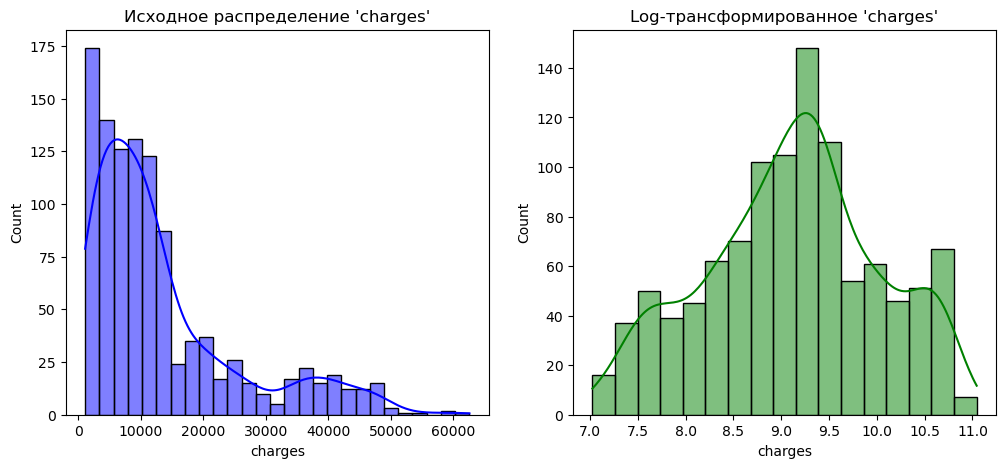

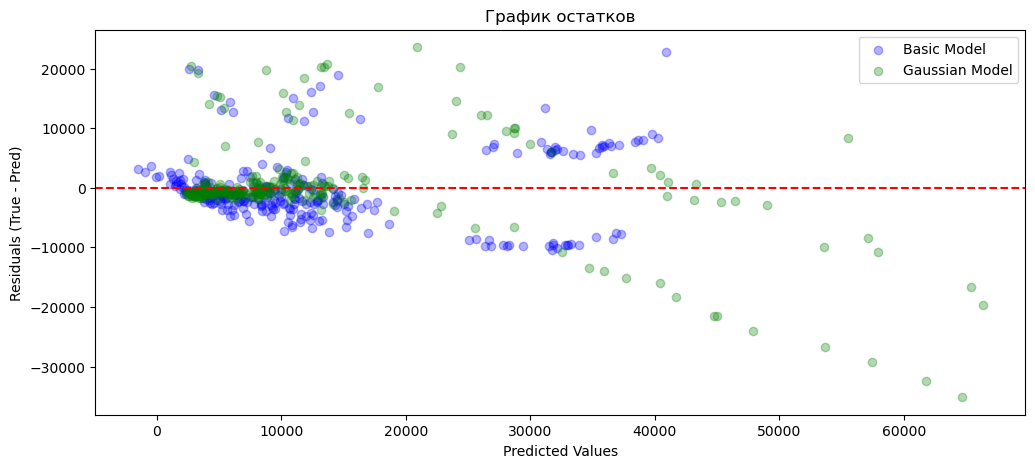

In [23]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer

df = pd.read_csv("insurance.csv")

df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ["age", "bmi", "children"]
preprocessor_basic = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_features)],
    remainder="passthrough",
)

X_train_basic = preprocessor_basic.fit_transform(X_train)
X_test_basic = preprocessor_basic.transform(X_test)

model_basic = LinearRegression()
model_basic.fit(X_train_basic, y_train)

y_pred_basic = model_basic.predict(X_test_basic)
mse_basic = mean_squared_error(y_test, y_pred_basic)


preprocessor_power = ColumnTransformer(
    transformers=[
        ("num", PowerTransformer(method="yeo-johnson", standardize=True), numeric_features)
    ],
    remainder="passthrough",
)

X_train_power = preprocessor_power.fit_transform(X_train)
X_test_power = preprocessor_power.transform(X_test)

y_train_log = np.log1p(y_train)

model_power = LinearRegression()
model_power.fit(X_train_power, y_train_log)

y_pred_log = model_power.predict(X_test_power)

y_pred_power = np.expm1(y_pred_log)

mse_power = mean_squared_error(y_test, y_pred_power)


print("\nРезультаты:")
print(f"1. Basic Model (StandardScaler): MSE = {mse_basic:,.2f} | RMSE = {np.sqrt(mse_basic):,.2f}")
print(f"2. Gaussian Model (Power + Log): MSE = {mse_power:,.2f} | RMSE = {np.sqrt(mse_power):,.2f}")

improvement = (mse_basic - mse_power) / mse_basic * 100
print(f"Улучшение качества (снижение ошибки): {improvement:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color="blue")
plt.title("Исходное распределение 'charges'")

plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True, color="green")
plt.title("Log-трансформированное 'charges'")

plt.show()

plt.figure(figsize=(12, 5))
plt.scatter(y_pred_basic, y_test - y_pred_basic, alpha=0.3, label="Basic Model", color="blue")
plt.scatter(y_pred_power, y_test - y_pred_power, alpha=0.3, label="Gaussian Model", color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (True - Pred)")
plt.legend()
plt.title("График остатков")
plt.show()

**8.** Добавим в наши данные немного мусора. Сделайте колонку с id пациента (числа от 0 до ...) и его любимым цветом (случайный цвет, заданный тремя параметрами RGB, распределение случайных величин - на ваше усмотрение). Проведите предобработку данных, которую посчитаете нужной, только не выбрасывайте наши мусорные колонки. Чтобы поменьше заниматься подбором параметров, обучим следующием модели:

- псевдообратный регрессор
- псевдообратный регрессор с L2 регуляризацией
- псевдообратный регрессор, но мы выбросили id
- псевдообратный регрессор с L2 регуляризацией, но мы выбросили id
- псевдообратный регрессов, но мы выбросили и id, и цвета
- псевдообратный регрессор с L2 регуляризацией, но мы выбросили и id, и цвета

Вычислите для каждой модели $R^2$ и скорректированный $R^2$ на тестовом и на тренировочном множествах, сведите в табличку. Какие выводы можно сделать из увиденного? 

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("insurance.csv")

np.random.seed(42)
N = df.shape[0]

df["patient_id"] = np.arange(N)

df["color_r"] = np.random.randint(0, 256, size=N)
df["color_g"] = np.random.randint(0, 256, size=N)
df["color_b"] = np.random.randint(0, 256, size=N)

garbage_cols = ["patient_id", "color_r", "color_g", "color_b"]
real_numeric_cols = ["age", "bmi", "children"]
categorical_cols = ["sex", "smoker", "region"]

all_cols = real_numeric_cols + garbage_cols + categorical_cols
target = "charges"

X = df[real_numeric_cols + garbage_cols + categorical_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def get_adj_r2(r2, n, p):
    """
    n: количество примеров
    p: количество признаков (после OHE)
    """
    if n - p - 1 <= 0:
        return 0  
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


results = []


def train_evaluate(name, drop_cols, use_l2=False):
    X_tr = X_train.copy()
    X_te = X_test.copy()

    if drop_cols:
        X_tr = X_tr.drop(columns=drop_cols, errors="ignore")
        X_te = X_te.drop(columns=drop_cols, errors="ignore")

    current_numeric = [c for c in X_tr.columns if c in real_numeric_cols + garbage_cols]
    current_categorical = [c for c in X_tr.columns if c in categorical_cols]

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), current_numeric),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), current_categorical),
    ])

    if use_l2:
        model = Ridge(alpha=1.0)  
    else:
        model = LinearRegression()

    clf = Pipeline([("prep", preprocessor), ("model", model)])

    clf.fit(X_tr, y_train)

    y_pred_train = clf.predict(X_tr)
    y_pred_test = clf.predict(X_te)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    X_tr_transformed = clf.named_steps["prep"].transform(X_tr)
    n_train, p_train = X_tr_transformed.shape
    n_test = X_test.shape[0]  

    adj_r2_train = get_adj_r2(r2_train, n_train, p_train)
    adj_r2_test = get_adj_r2(r2_test, n_test, p_train)

    results.append({
        "Модель": name,
        "L2": "Да" if use_l2 else "Нет",
        "Train R2": r2_train,
        "Test R2": r2_test,
        "Train Adj R2": adj_r2_train,
        "Test Adj R2": adj_r2_test,
        "Diff R2 (Overfit)": r2_train - r2_test,
    })



train_evaluate("Full Garbage", [], use_l2=False)
train_evaluate("Full Garbage", [], use_l2=True)

train_evaluate("No ID (Has Color)", ["patient_id"], use_l2=False)
train_evaluate("No ID (Has Color)", ["patient_id"], use_l2=True)

train_evaluate("Clean Data", ["patient_id", "color_r", "color_g", "color_b"], use_l2=False)
train_evaluate("Clean Data", ["patient_id", "color_r", "color_g", "color_b"], use_l2=True)

df_res = pd.DataFrame(results)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
print(df_res.round(4))

              Модель   L2  Train R2  Test R2  Train Adj R2  Test Adj R2  Diff R2 (Overfit)
0       Full Garbage  Нет    0.7431   0.7809        0.7401       0.7706            -0.0379
1       Full Garbage   Да    0.7430   0.7806        0.7401       0.7702            -0.0375
2  No ID (Has Color)  Нет    0.7428   0.7825        0.7401       0.7731            -0.0397
3  No ID (Has Color)   Да    0.7428   0.7821        0.7401       0.7728            -0.0394
4         Clean Data  Нет    0.7417   0.7836        0.7398       0.7769            -0.0419
5         Clean Data   Да    0.7417   0.7833        0.7398       0.7766            -0.0416
